In [1]:
import memilio.simulation.secir as secir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, date
import time
import seaborn as sns
plt.style.use("seaborn")

import scipy.stats

In [2]:
from utils_SA import simulate_model, generate_output_daywise

In [3]:
# openturns libraries

from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

import pickle

In [4]:
# Define Comartment names
compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']

In [5]:
with open('Studies/study_dead_sobol_10000.pkl', 'rb') as f:
    size = pickle.load(f)
    input_factor_names = pickle.load(f)
    distributions = pickle.load(f) # saved as coll (collection of distributions)
    static_params = pickle.load(f)
    inputDesign = pickle.load(f)
    sim_out = pickle.load(f)
    runtime = pickle.load(f)

In [6]:
print(f"The Monte Carlo experiment needed {runtime} s.")

The Monte Carlo experiment needed 1.0910992622375488 s.


In [7]:
aggregation_function = "max"

if aggregation_function == "max":
    output_agg = np.max(sim_out, axis = 1, keepdims = True)
elif aggregation_function == "sum":
    output_agg = np.sum(sim_out, axis = 1, keepdims=True)
elif aggregation_function == "mean":
    output_agg = np.mean(sim_out, axis = 1, keepdims=True)

In [8]:
outputArray = np.array(sim_out)
outputArray.shape

(760000, 101)

In [9]:
sim_out.shape

(760000, 101)

In [10]:
output_agg.shape

(760000, 1)

In [123]:
inputDesign[0]

74

# Display distribution of samples

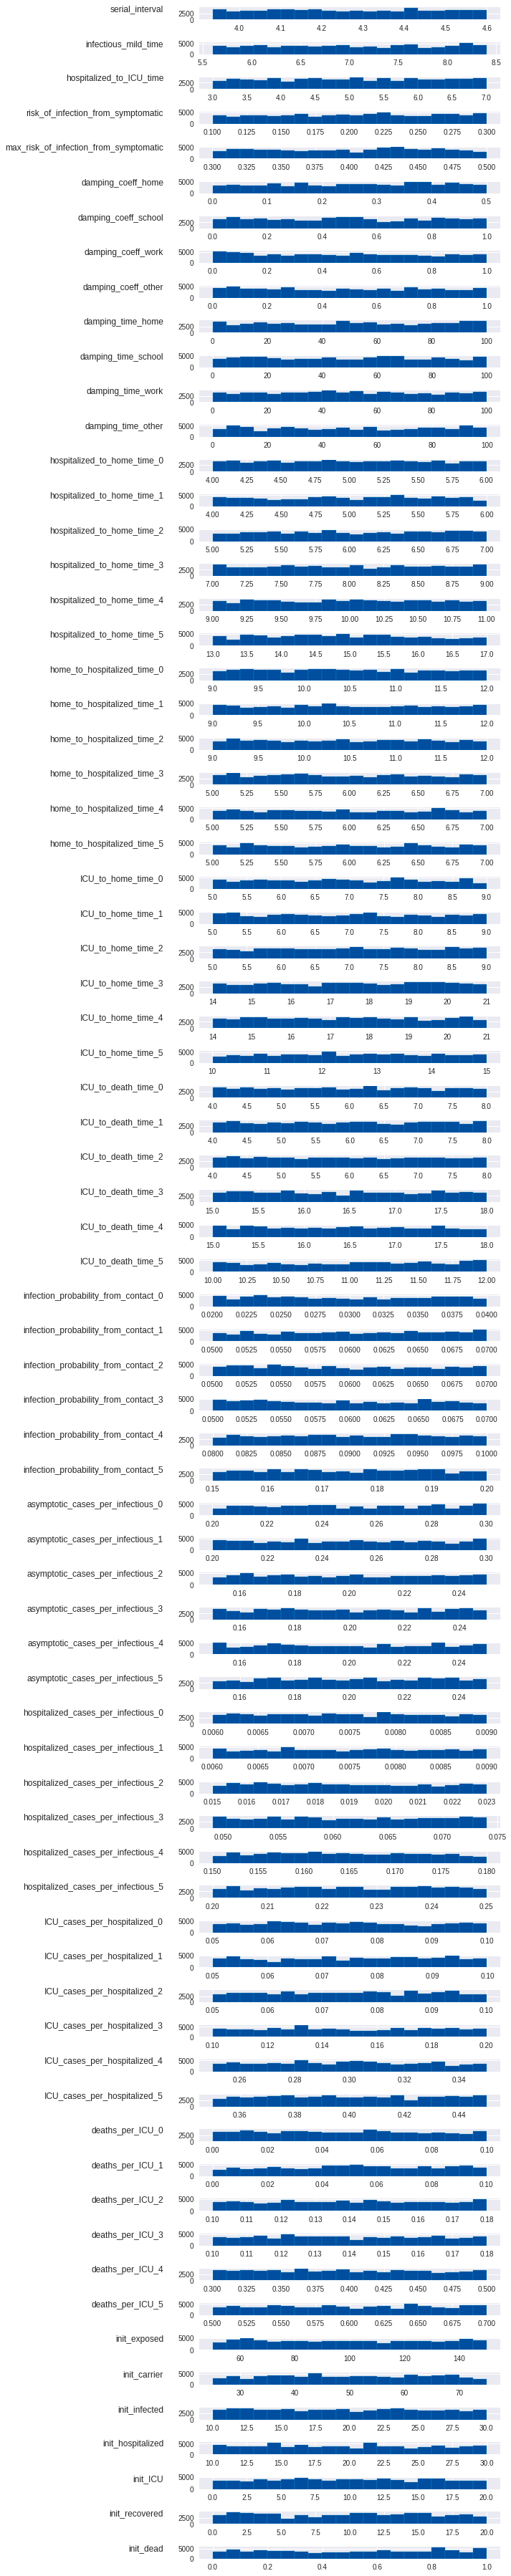

In [64]:
n = len(distributions)
n_bins = 20
fig, axes = plt.subplots(n, 1, figsize=(10, 50))
inputArray = np.array(inputDesign)

for i in range(n):
    axes[i].hist(inputArray[:, i], bins = n_bins, facecolor = '#004e9f', edgecolor = '#169acf')
    axes[i].set_ylabel(input_factor_names[i], rotation = 0, fontsize = 12, labelpad = 20, ha = 'right')
plt.tight_layout()
plt.show()

In [66]:
out_end = outputArray[:, -1]
out_end.shape

(76000,)

In [68]:
def mean_CI(data, conf = 0.95):
    n = len(data)
    m, se = np.mean(data), scipy.stats.sem(data)
    h = se * scipy.stats.t.ppf((1+conf)/2., n-1)
    
    m_id = np.abs(data - np.mean(data)).argmin()
    
    return m_id, h

In [69]:
len(outputArray)

76000

In [70]:
conf = 0.95
m_id, h = mean_CI(out_end, conf)

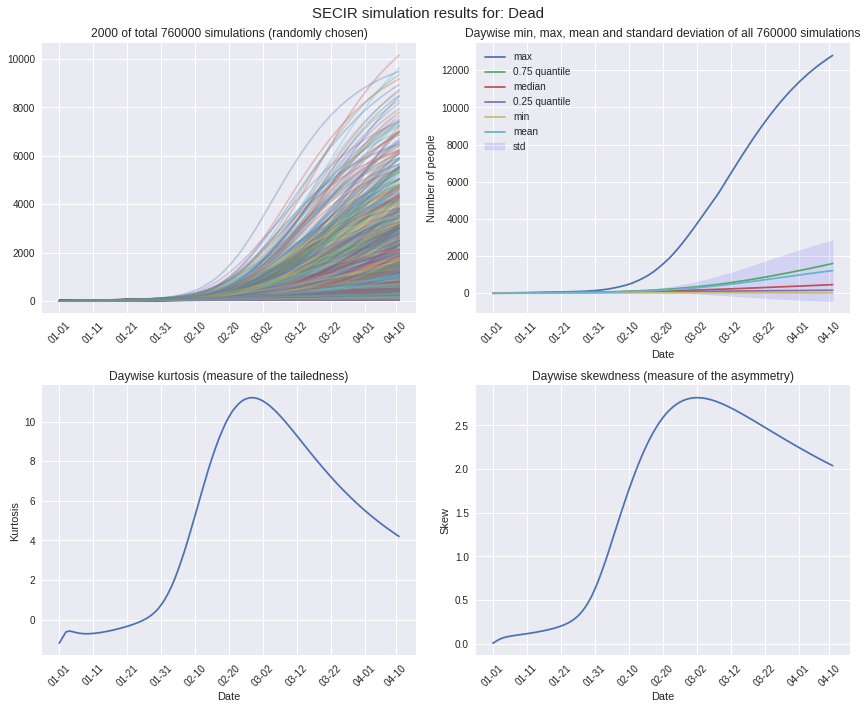

In [11]:
n_outputs = 2000
conf = 0.95

randidx = np.sort(np.random.randint(0, outputArray.shape[0], n_outputs))
#print(randidx)

title = f"SECIR simulation results for: {compartments[static_params['output_index'][0]]}"

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10), tight_layout = True)
fig.suptitle(title, fontsize = 15)

num_time_points = static_params['days'] + 1

data = outputArray[randidx, :]
x = np.arange(num_time_points)

days = static_params['days']
start_day = 1
start_month = 1
start_year = 2019

# Plot Results
datelist = np.array(
    pd.date_range(
        datetime(start_year, start_month, start_day),
        periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1) * 10)
tick_range[-1] -= 1


for i in range(n_outputs):
    axs[0, 0].plot(x, data[i, :], alpha=0.3 )

axs[0, 0].set_title(f"{n_outputs} of total {len(outputArray)} simulations (randomly chosen)")

mean_result = np.array([np.mean(outputArray[:, i]) for i in range(num_time_points)])
#n = len(data)
#ci_result = np.array([scipy.stats.sem(data[:, i]) * scipy.stats.t.ppf((1+conf)/2., n-1) for i in range(num_time_points)])
std_result = np.array([np.std(outputArray[:, i]) for i in range(num_time_points)])

median_result = np.array([np.quantile(outputArray[:, i], q = 0.5) for i in range(num_time_points)])
low_quantile_result = np.array([np.quantile(outputArray[:, i], q = 0.25) for i in range(num_time_points)])
high_quantile_result = np.array([np.quantile(outputArray[:, i], q = 0.75) for i in range(num_time_points)])

kurtosis_result = np.array([scipy.stats.kurtosis(outputArray[:, i]) for i in range(num_time_points)])
skew_result = np.array([scipy.stats.skew(outputArray[:, i]) for i in range(num_time_points)])

min_result = np.array([np.min(outputArray[:, i]) for i in range(num_time_points)])
max_result = np.array([np.max(outputArray[:, i]) for i in range(num_time_points)])                      

axs[0, 1].plot(x, max_result, label = 'max')
axs[0, 1].plot(x, high_quantile_result, label = '0.75 quantile')
axs[0, 1].plot(x, median_result, label = 'median')
axs[0, 1].plot(x, low_quantile_result, label = '0.25 quantile')
axs[0, 1].plot(x, min_result, label = "min")
axs[0, 1].plot(x, mean_result, label = 'mean')
axs[0, 1].fill_between(x, 
                    (mean_result - std_result), (mean_result + std_result), 
                    color = 'b', alpha = .1, label = "std")

#axs[1].fill_between(x, (mean_result - ci_result), (mean_result + ci_result), color = 'b', alpha = .1)
#axs[1].set_title(f"Daywise mean with {conf} confidence interval.")
axs[0, 1].set_title(f"Daywise min, max, mean and standard deviation of all {len(outputArray)} simulations")
axs[0, 1].legend()

axs[1, 0].plot(x, kurtosis_result, label = 'kurtosis')
axs[1, 0].set_title(f"Daywise kurtosis (measure of the tailedness)")
axs[1, 1].plot(x, skew_result, label = 'skew')
axs[1, 1].set_title(f"Daywise skewdness (measure of the asymmetry)")

for j in range(2):
    for k in range(2):
        axs[j, k].set_xticks(tick_range)
        axs[j, k].set_xticklabels(datelist[tick_range], rotation=45)
    axs[0, k].set(ylabel = "Number of people", xlabel = "Date")
axs[1, 0].set(ylabel = "Kurtosis", xlabel = "Date")
axs[1, 1].set(ylabel = "Skew", xlabel = "Date")

plt.show()

### Histogram of aggregated simulation output

In [12]:
print(aggregation_function, compartments[static_params['output_index'][0]])
print(output_agg.shape)

max Dead
(760000, 1)


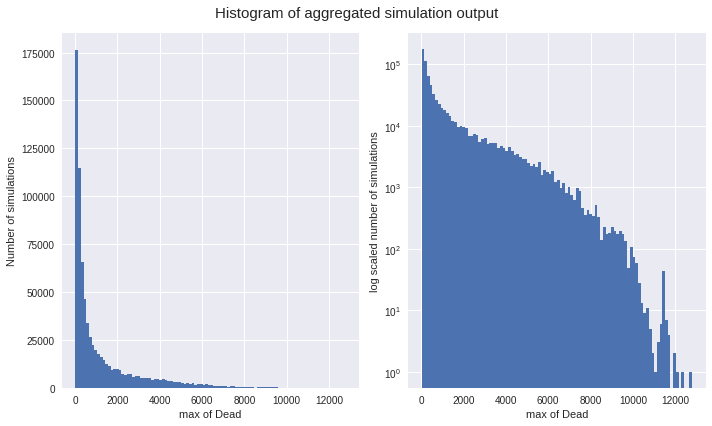

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6), tight_layout = True)
fig.suptitle("Histogram of aggregated simulation output", fontsize = 15)
axs[0].hist(output_agg, bins = 100, density = False, log = False)
axs[0].set(xlabel = f"{aggregation_function} of {compartments[static_params['output_index'][0]]}", 
          ylabel = "Number of simulations")
axs[1].hist(output_agg, bins = 100, density = False, log = True)
axs[1].set(xlabel = f"{aggregation_function} of {compartments[static_params['output_index'][0]]}", 
          ylabel = "log scaled number of simulations")
plt.show()

Text(0.5, 1.0, 'Estimated density of max of simulation output: Dead')

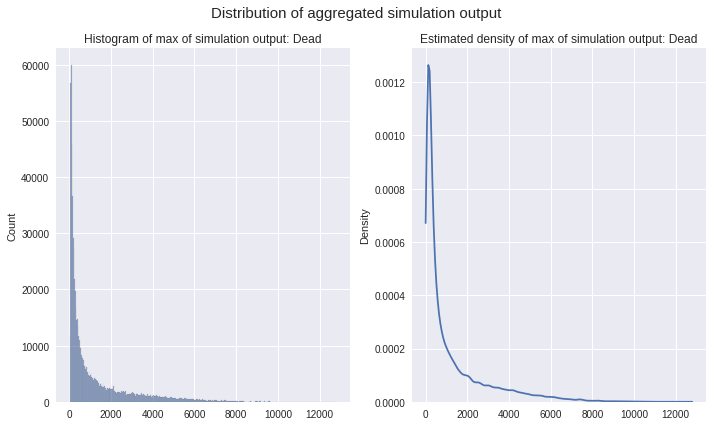

In [14]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6), tight_layout = True)
fig.suptitle("Distribution of aggregated simulation output", fontsize = 15)
sns.histplot(ax = axs[0], data = output_agg, kde = False, legend = False)
sns.kdeplot(ax = axs[1], data = output_agg, legend = False, clip = [0, np.max(output_agg)])
axs[0].set_title(f"Histogram of {aggregation_function} of simulation output: {compartments[static_params['output_index'][0]]}")
axs[1].set_title(f"Estimated density of {aggregation_function} of simulation output: {compartments[static_params['output_index'][0]]}")

# Compute sensitivity indices

In [15]:
outputDesign = ot.Sample(output_agg)
sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)

agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
print("Agg. first order indices: ", agg_first_order)
print("Agg. total order indices: ", agg_total_order)

first_order = sensitivityAnalysis.getFirstOrderIndices()
total_order = sensitivityAnalysis.getTotalOrderIndices()
print("First order indices: ", first_order)
print("Total order indices: ", total_order)

Agg. first order indices:  [0.158642,0.0176453,-0.00728981,0.0509774,-0.0122656,-0.00585061,0.0146969,0.00771679,0.020322,0.01857,0.0215371,0.018138,0.0299871,-0.0122654,-0.0122672,-0.0122768,-0.0122997,-0.0125576,-0.0123484,-0.0122653,-0.0122668,-0.0122586,-0.012237,-0.0107275,-0.0127423,-0.0122659,-0.0122645,-0.01224,-0.0123772,-0.0118943,-0.0105805,-0.0122681,-0.0122677,-0.0121986,-0.0122352,-0.0111997,-0.011982,-0.0126762,-0.013244,-0.00158682,0.00109231,-0.0117311,-0.0114911,-0.0122456,-0.0123598,-0.0118808,-0.0114702,-0.0119603,-0.0124768,-0.0122656,-0.0122638,-0.0122647,-0.012442,-0.0123893,-0.0114812,-0.0122658,-0.0122693,-0.0123306,-0.0121642,-0.0139714,-0.013264,-0.0122681,-0.0122709,-0.0123451,-0.0115873,-0.00992348,-0.0130437,-0.00769914,-0.0103156,-0.0120836,-0.0122668,-0.0121576,-0.0122678,-0.0122921]#74
Agg. total order indices:  [0.346081,0.0471519,0.0246417,0.133166,0,0.0505187,0.105634,0.0995336,0.0953131,0.125572,0.219121,0.218829,0.204385,4.0099e-10,8.9852e-10,2.879

In [16]:
print(sensitivityAnalysis.getConfidenceLevel())

0.95


In [17]:
firstCI = sensitivityAnalysis.getFirstOrderIndicesInterval()
totalCI = sensitivityAnalysis.getTotalOrderIndicesInterval()
total = np.array(sensitivityAnalysis.getAggregatedTotalOrderIndices())
first = np.array(sensitivityAnalysis.getAggregatedFirstOrderIndices())

In [18]:
sorted_ids = list(map(int, np.argsort(total)))
print(sorted_ids)
type(sorted_ids[0])

[4, 19, 49, 13, 20, 14, 55, 50, 56, 25, 26, 31, 32, 72, 21, 61, 62, 15, 27, 51, 73, 43, 63, 33, 57, 70, 16, 34, 44, 71, 47, 22, 28, 69, 52, 48, 17, 46, 18, 64, 37, 58, 45, 36, 35, 30, 29, 53, 60, 38, 59, 23, 54, 41, 42, 24, 68, 66, 65, 67, 2, 39, 40, 1, 5, 8, 7, 6, 9, 3, 12, 11, 10, 0]


int

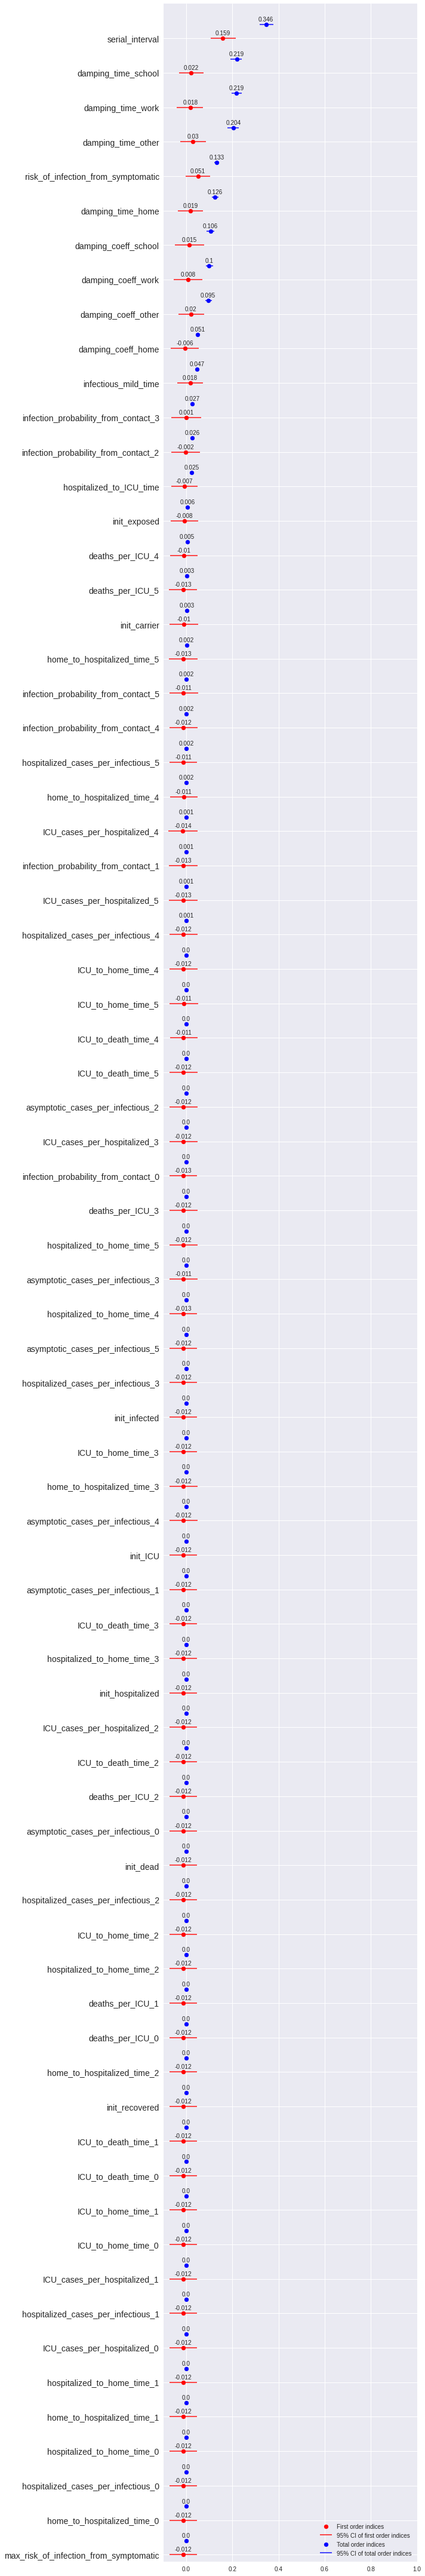

In [19]:
sorted_ids = list(map(int, np.argsort(total)))
n = len(distributions)
alp = 0.7
lw = 2
fig, axes = plt.subplots(1, 1, figsize=(10, 60))
inputArray = np.array(inputDesign)
x = np.arange(0, 1.1, 0.2)
y = np.arange(0, len(first), 1)
space = 0.4
y2 = np.arange(0+space, len(total)+space, 1)


axes.scatter(first[sorted_ids], y, label = "First order indices", c = 'red')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='red', linestyles='-', lw=lw, label = "95% CI of first order indices", alpha = alp)
axes.scatter(total[sorted_ids], y2, label = "Total order indices", c = 'blue')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='blue', linestyles='-', lw=lw, label = "95% CI of total order indices", alpha = alp)
for i, j in enumerate(sorted_ids):
    plt.hlines(y=y[i], xmin=firstCI.getMarginal(j).getLowerBound()[0], 
               xmax=firstCI.getMarginal(j).getUpperBound()[0], 
               colors='red', linestyles='-', lw=lw, alpha = alp)
    plt.hlines(y=y2[i], xmin=totalCI.getMarginal(j).getLowerBound()[0], 
               xmax=totalCI.getMarginal(j).getUpperBound()[0], 
               colors='blue', linestyles='-', lw=lw, alpha = alp)
    plt.annotate(str(np.round(first[sorted_ids[i]], 3)), (first[sorted_ids[i]], y[i]+ 0.25*space), ha='center')
    plt.annotate(str(np.round(total[sorted_ids[i]], 3)), (total[sorted_ids[i]], y2[i]+ 0.25*space), ha='center')
    

#axes.set_ylabel(input_factor_names[i], rotation = 0, fontsize = 12, labelpad = 20, ha = 'right')
axes.set_xticks(x)
axes.set_yticks(y)
axes.set_yticklabels([input_factor_names[k] for k in sorted_ids], fontsize = 14)
plt.legend(loc='lower right')
plt.ylim([-0.2, n])
#plt.xlim([-0.1, 1])
plt.tight_layout()
plt.show()

In [21]:
eps = 0

relevant = total[total > eps]
print(relevant)
#print(np.sort(total))
print(len(total), len(relevant))

sorted_ids = list(map(int, np.argsort(total)))
print(sorted_ids)
sorted_ids = sorted_ids[-len(relevant):]
print(sorted_ids)

[3.46081255e-01 4.71518861e-02 2.46416533e-02 1.33165890e-01
 5.05187268e-02 1.05633872e-01 9.95336319e-02 9.53131234e-02
 1.25571669e-01 2.19120821e-01 2.18828648e-01 2.04384691e-01
 4.00989987e-10 8.98519935e-10 2.87952952e-07 1.70790364e-05
 1.62959063e-04 1.96926819e-04 1.57721647e-10 8.36752472e-10
 8.22722951e-08 3.48691089e-05 1.52965591e-03 2.39969698e-03
 8.16411823e-09 1.09472763e-08 8.55042703e-07 3.55114096e-05
 4.95637332e-04 4.80861702e-04 1.21677416e-08 1.66400416e-08
 1.50657263e-06 1.84533782e-05 3.65697348e-04 3.07153187e-04
 2.26491736e-04 1.41550218e-03 2.62328041e-02 2.66234692e-02
 1.71086370e-03 1.79531662e-03 1.24359665e-06 1.85785723e-05
 2.47369453e-04 1.90896812e-04 3.36337453e-05 1.09793110e-04
 3.81976394e-10 2.23949910e-09 1.03480463e-06 9.44024275e-05
 6.86947125e-04 1.60254442e-03 9.61908883e-10 2.90393599e-09
 1.57885771e-06 2.41328106e-04 1.42295122e-03 8.33871203e-04
 9.44760406e-08 1.25555612e-07 1.43430306e-06 2.11523667e-04
 4.80330497e-03 3.496377

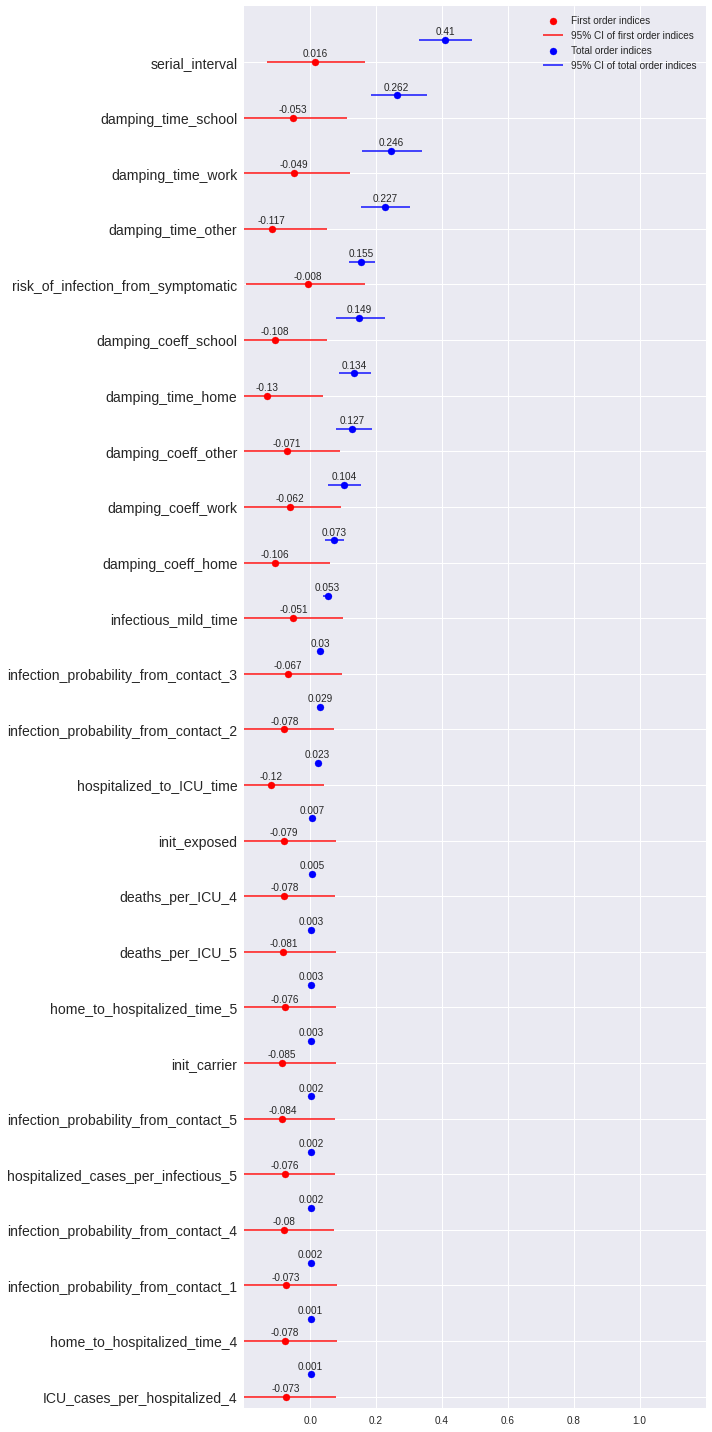

In [61]:
n = len(distributions)
alp = 0.7
lw = 2
fig, axes = plt.subplots(1, 1, figsize=(10, 20))
inputArray = np.array(inputDesign)
x = np.arange(0, 1.1, 0.2)
y = np.arange(0, len(sorted_ids), 1)
space = 0.4
y2 = np.arange(0+space, len(sorted_ids)+space, 1)


axes.scatter(first[sorted_ids], y, label = "First order indices", c = 'red')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='red', linestyles='-', lw=lw, label = "95% CI of first order indices", alpha = alp)
axes.scatter(total[sorted_ids], y2, label = "Total order indices", c = 'blue')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='blue', linestyles='-', lw=lw, label = "95% CI of total order indices", alpha = alp)
for i, j in enumerate(sorted_ids):
    plt.hlines(y=y[i], xmin=firstCI.getMarginal(j).getLowerBound()[0], 
               xmax=firstCI.getMarginal(j).getUpperBound()[0], 
               colors='red', linestyles='-', lw=lw, alpha = alp)
    plt.hlines(y=y2[i], xmin=totalCI.getMarginal(j).getLowerBound()[0], 
               xmax=totalCI.getMarginal(j).getUpperBound()[0], 
               colors='blue', linestyles='-', lw=lw, alpha = alp)
    plt.annotate(str(np.round(first[sorted_ids[i]], 3)), (first[sorted_ids[i]], y[i]+ 0.25*space), ha='center')
    plt.annotate(str(np.round(total[sorted_ids[i]], 3)), (total[sorted_ids[i]], y2[i]+ 0.25*space), ha='center')
    

#axes.set_ylabel(input_factor_names[i], rotation = 0, fontsize = 12, labelpad = 20, ha = 'right')
axes.set_xticks(x)
axes.set_yticks(y)
axes.set_yticklabels([input_factor_names[k] for k in sorted_ids], fontsize = 14)
plt.legend(loc='upper right')
plt.ylim([-0.2, len(sorted_ids)])
plt.xlim([-0.2, 1.2])
plt.tight_layout()
plt.show()

# Second order Sensitivity Analysis

In [62]:
with open('Studies/study_dead_sobol_second_order.pkl', 'rb') as f:
    size = pickle.load(f)
    input_factor_names = pickle.load(f)
    distributions = pickle.load(f) # saved as coll (collection of distributions)
    static_params = pickle.load(f)
    inputDesign = pickle.load(f)
    sim_out = pickle.load(f)

In [63]:
aggregation_function = "max"

if aggregation_function == "max":
    output_agg = np.max(sim_out, axis = 1, keepdims = True)
elif aggregation_function == "sum":
    output_agg = np.sum(sim_out, axis = 1, keepdims=True)
elif aggregation_function == "mean":
    output_agg = np.mean(sim_out, axis = 1, keepdims=True)
    
outputDesign = ot.Sample(output_agg)
sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)

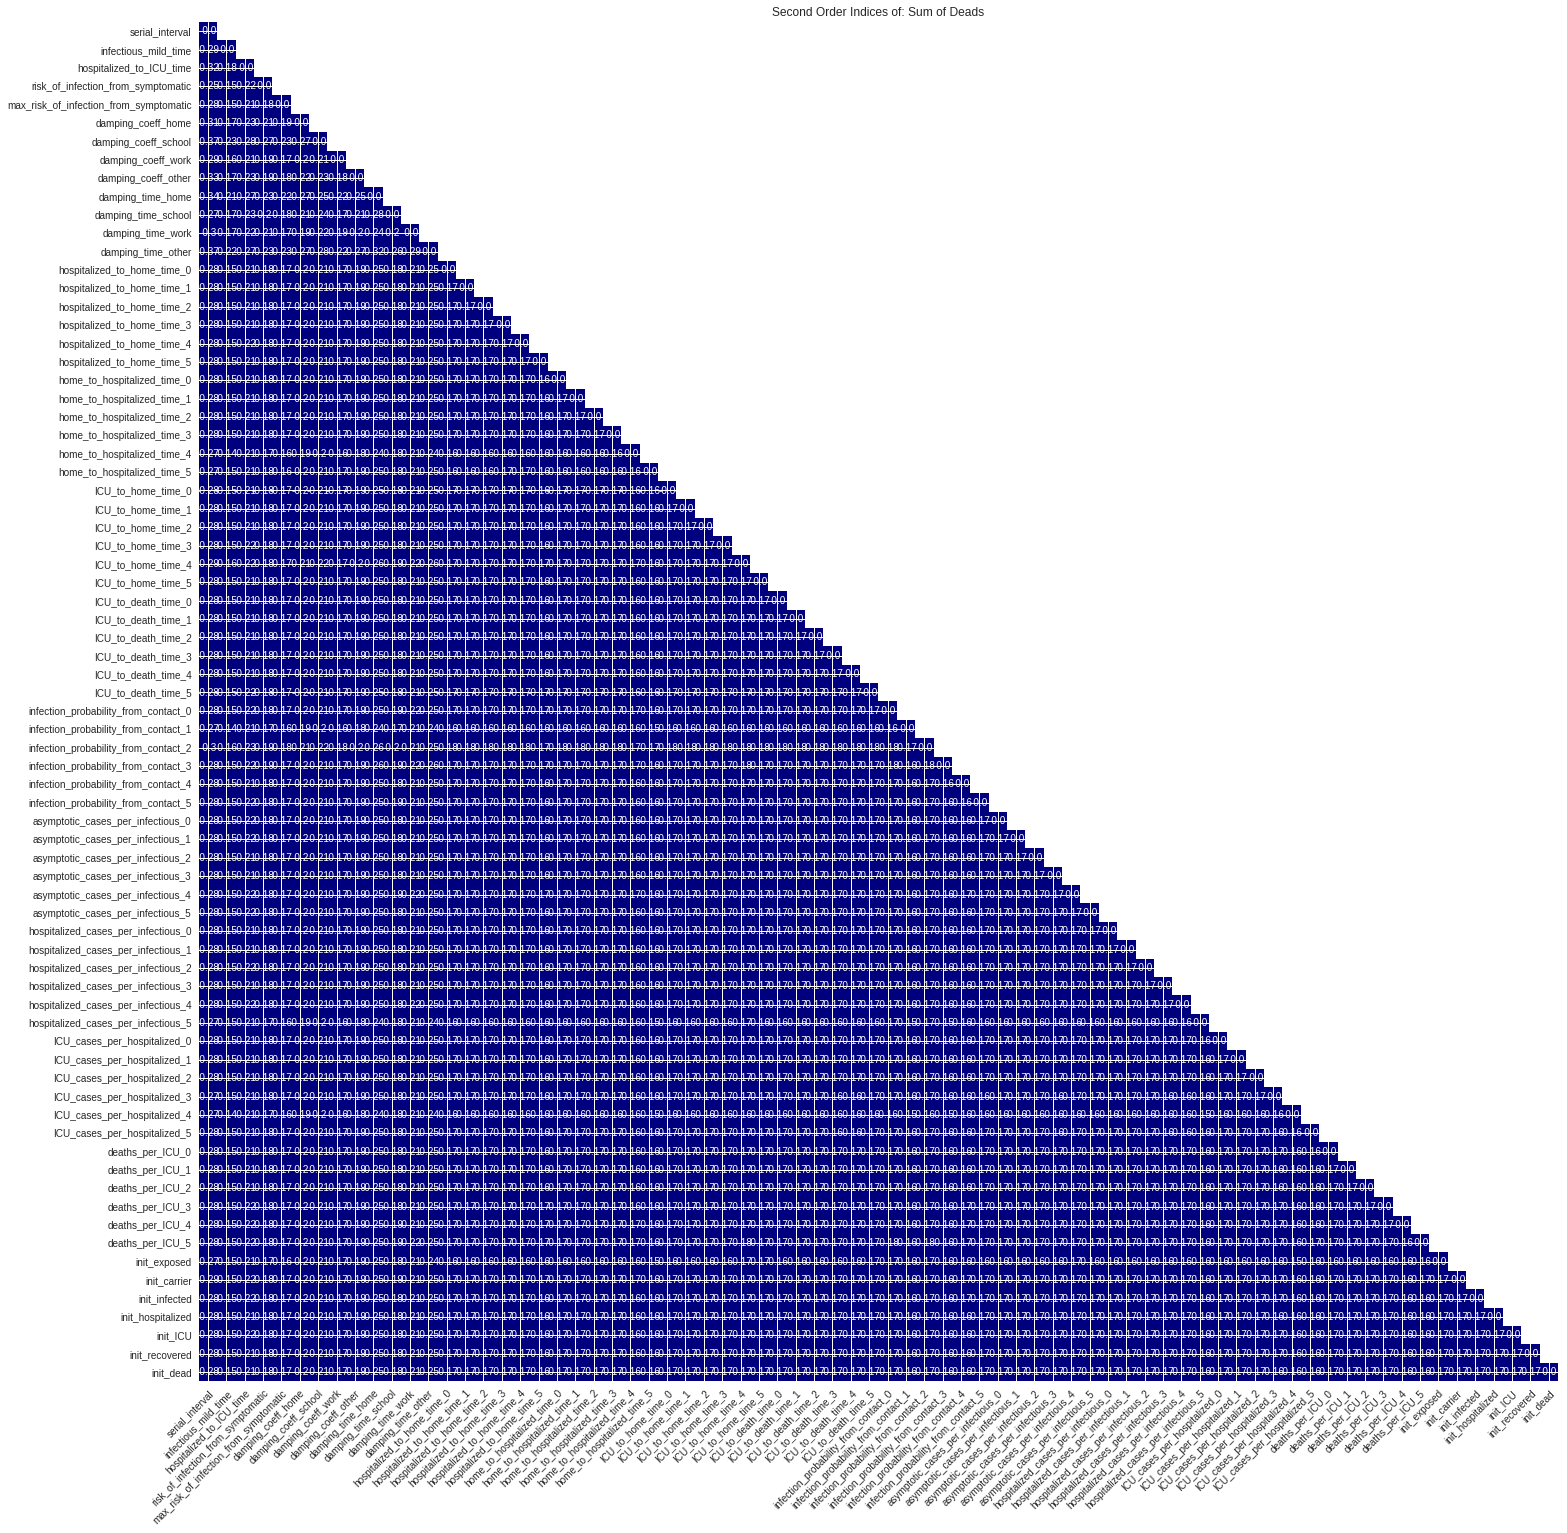

In [64]:
second_order = sensitivityAnalysis.getSecondOrderIndices()*(-1)
mask = np.ones_like(second_order)
mask[np.tril_indices_from(mask)] = False

f, ax = plt.subplots(figsize = (25,25))

masked_secondorder = np.ma.array(second_order, mask = mask)

cmap = cm.get_cmap('jet', 25)
cmap.set_bad('w')

im = ax.imshow(masked_secondorder, 
                #mask = mask, linewidth = 1, annot = True, 
                       #xticklabels = input_factor_names, yticklabels = input_factor_names, 
                vmin = 0, vmax = 1, cmap = cmap)


ax.set_xticks(np.arange(len(input_factor_names)))
ax.set_yticks(np.arange(len(input_factor_names)))

ax.set_xticklabels(input_factor_names)
ax.set_yticklabels(input_factor_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(input_factor_names)):
    for j in range(len(input_factor_names)):
        text = ax.text(j, i, np.round(second_order[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Second Order Indices of: Sum of Deads")


plt.show()

In [65]:
eps = 1e-2
(np.array(second_order).sum(axis =1) > eps).sum()
second_order = np.array(second_order)
relevant_ids = np.array(second_order).sum(axis =1) > eps

In [66]:
relevant_names = np.array(input_factor_names)[relevant_ids]
len(relevant_names)

0

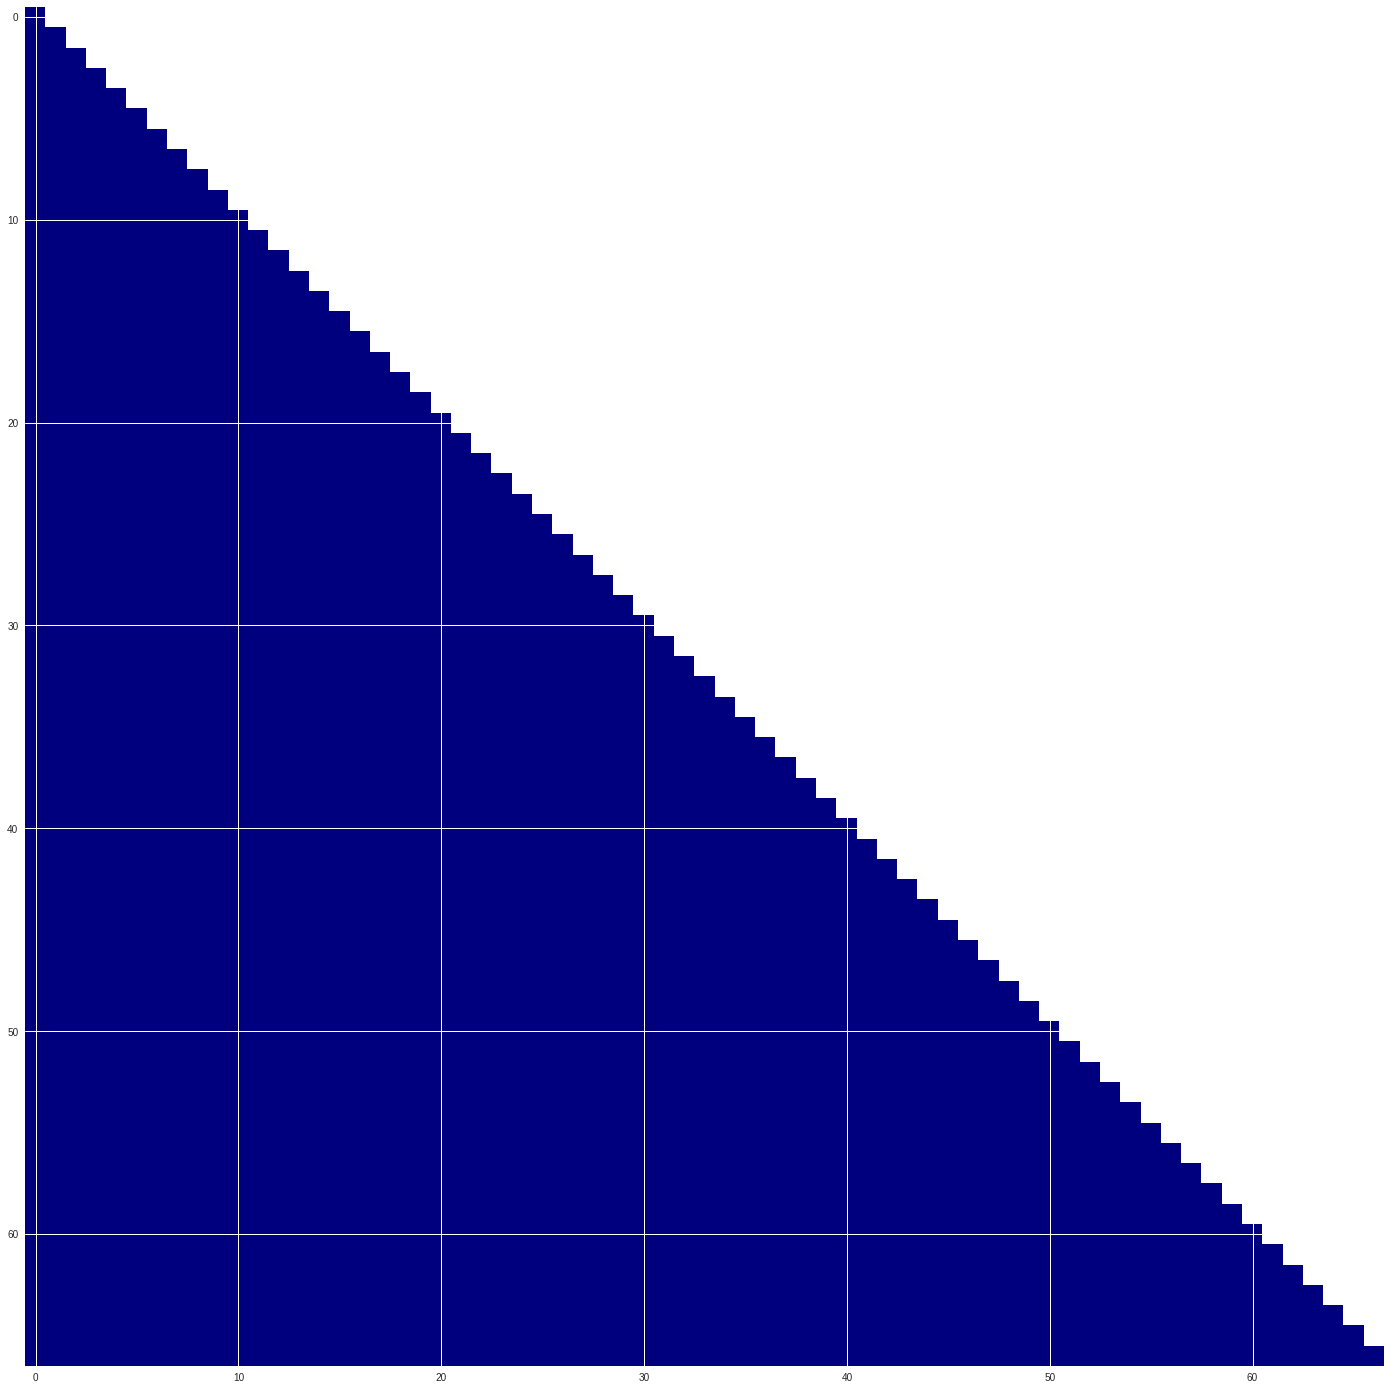

In [119]:
reduced_matrix = second_order[relevant_ids, :][:, relevant_ids]

mask = np.ones_like(reduced_matrix)
mask[np.tril_indices_from(mask)] = False

f, ax = plt.subplots(figsize = (25,25))

masked_secondorder = np.ma.array(reduced_matrix, mask = mask)

cmap = cm.get_cmap('jet', 25)
cmap.set_bad('w')

im = ax.imshow(masked_secondorder, 
                #mask = mask, linewidth = 1, annot = True, 
                       #xticklabels = input_factor_names, yticklabels = input_factor_names, 
                vmin = 0, vmax = 1, cmap = cmap)

ax.set_xticks(np.arange(len(relevant_names)))
ax.set_yticks(np.arange(len(relevant_names)))

ax.set_xticklabels(relevant_names)
ax.set_yticklabels(relevant_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(relevant_names)):
    for j in range(len(relevant_names)):
        text = ax.text(relevant_names[j], relevant_names[i], np.round(reduced_matrix[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Second Order Indices of: Sum of Deads")



plt.show()